# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value" ICML 2023 , using pyDVL.
https://proceedings.mlr.press/v202/kwon23e.html

The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [36]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

In [38]:
import pandas as pd

# Specify the URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Specify the column names
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

# Specify the data types for each column
data_types = {
    "age": int,
    "workclass": "category",
    "fnlwgt": int,
    "education": "category",
    "education-num": int,
    "marital-status": "category",
    "occupation": "category",
    "relationship": "category",
    "race": "category",
    "sex": "category",
    "capital-gain": int,
    "capital-loss": int,
    "hours-per-week": int,
    "native-country": "category",
    "income": "category",
}

# Load the dataset into a pandas DataFrame
data_adult = pd.read_csv(
    url,
    names=column_names,
    sep=",\s*",
    engine="python",
    na_values="?",
    dtype=data_types,
    nrows=10000,
)

# Drop categorical columns
data_adult = data_adult.drop(
    columns=[
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ]
)

data_adult = data_adult.sample(frac=1)
# Display the first few rows of the dataframe
print(data_adult.head())
data = Dataset.from_arrays(
    X=data_adult.drop(columns=["income"]).values,
    y=data_adult.loc[:, "income"].cat.codes.values,
)

      age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
9896   29  120359              9             0             0              40   
9859   43  355856             13             0             0              50   
8863   30  242460              9             0             0              50   
4255   44  228320              9             0             0              45   
1185   51  165637             14             0             0              40   

     income  
9896  <=50K  
9859  <=50K  
8863  <=50K  
4255   >50K  
1185  <=50K  


In [39]:

#model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
utility = Utility(model, data, Scorer("accuracy", default=0.0))

# Varying Objective scorer

> :warning: This is useless as oob does not rely on the scorer. It relies on point wise error metrics.  :warning:

In [40]:
def oob_func(utility, scorer_name):
    
    return(compute_data_oob(Utility(utility.model, utility.data, Scorer(scorer_name)), n_est=30, max_samples=0.6, progress=False))
scorer_name_list = ["accuracy"]#, "f1", "roc_auc", "balanced_accuracy","neg_log_loss"]
func = oob_func
kwargs_list = [{"scorer_name":scorer_name} for scorer_name in scorer_name_list]

roc_auc_ovo_weighted


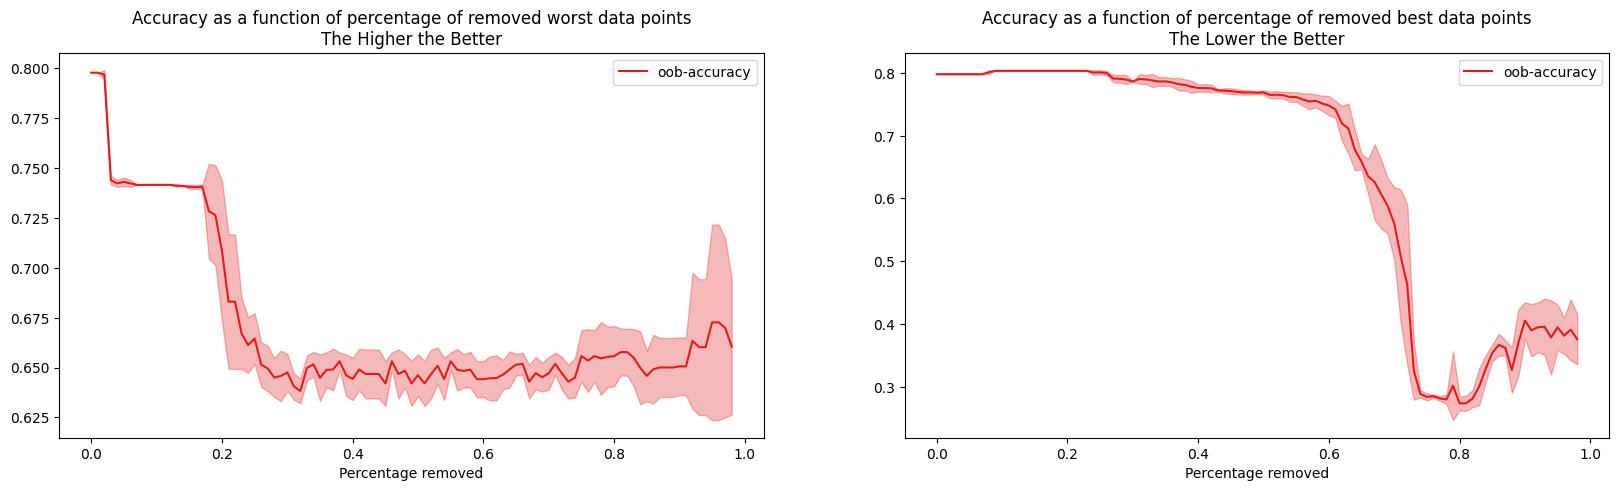

accuracy


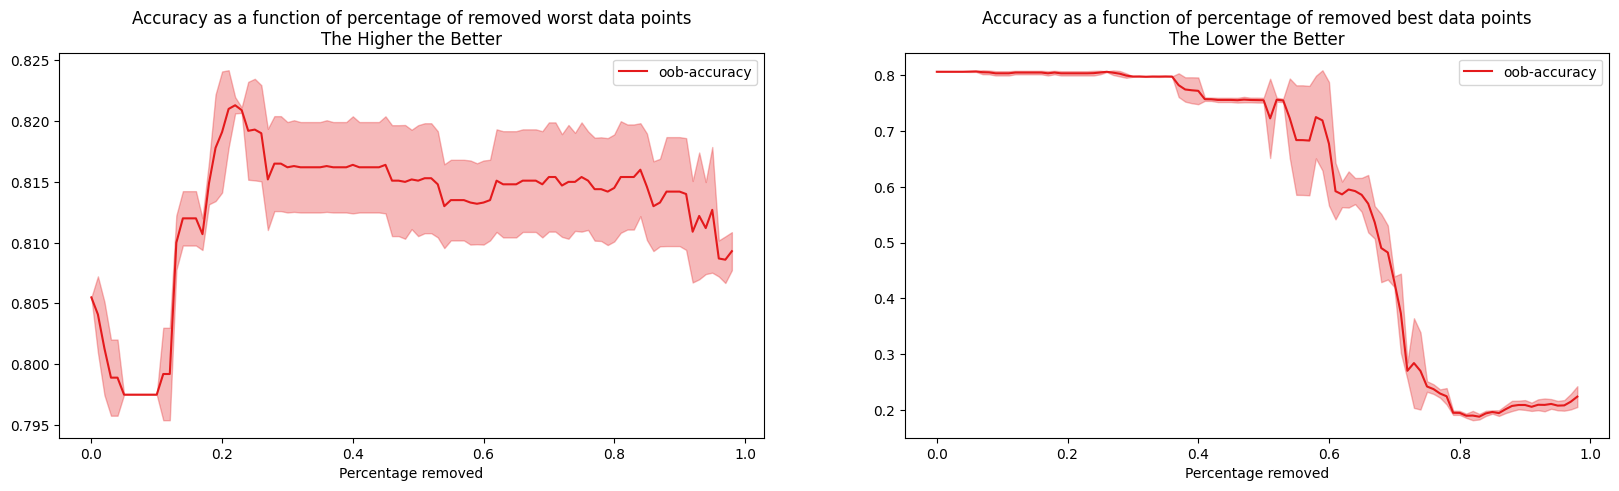

balanced_accuracy


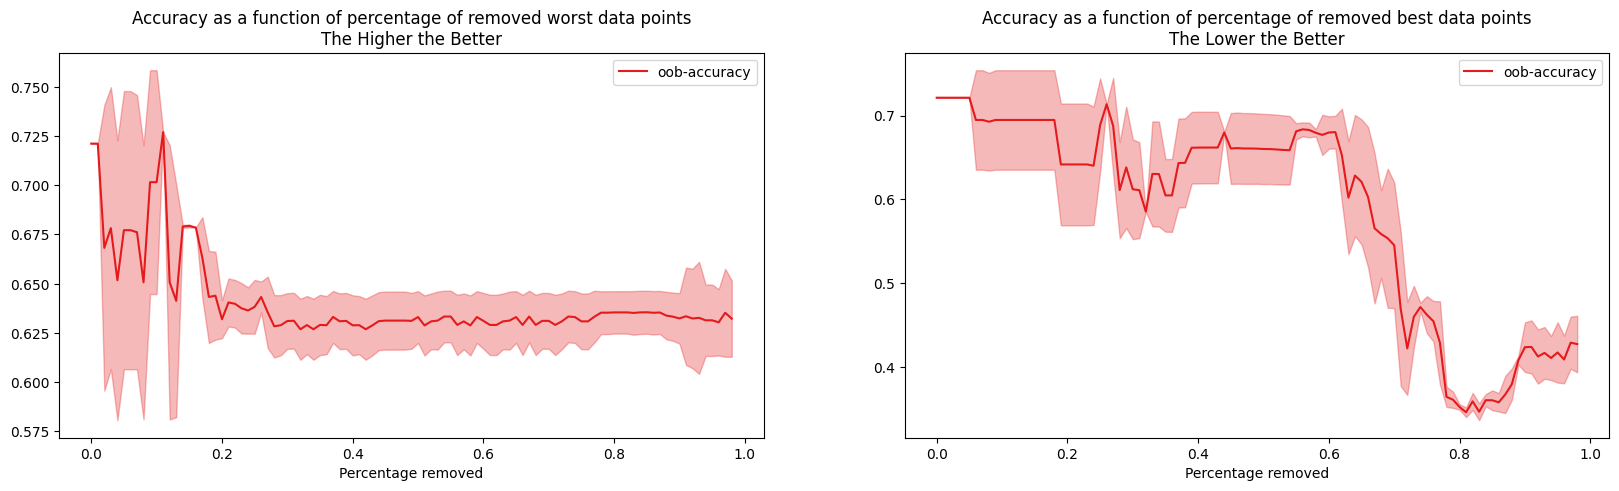

neg_log_loss


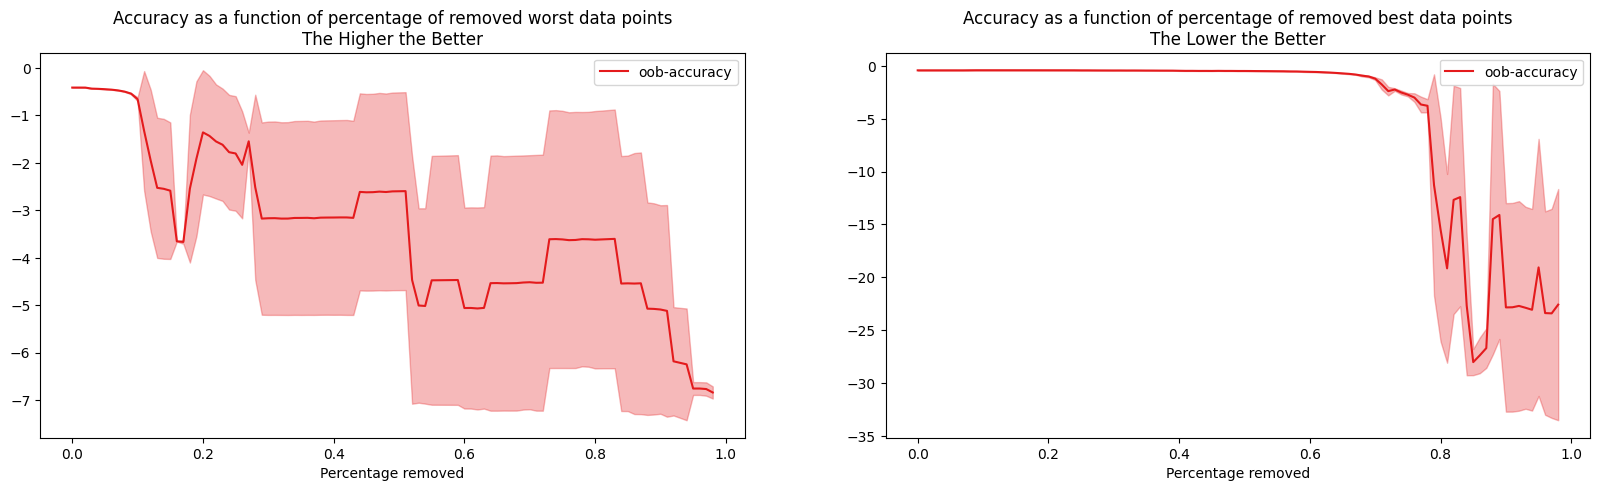

In [41]:

model_eval = DecisionTreeClassifier(max_depth=3)
for m in  ["roc_auc_ovo_weighted","accuracy",  "balanced_accuracy","neg_log_loss"]:#,  "f1", "roc_auc", "recall","jaccard","neg_brier_score","average_precision"
    print(m)
    utility_eval = Utility(model_eval, data, Scorer(m))
    n_iter = 5
    removal_percentages = np.arange(0, 0.99, 0.01)
    best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list,f_name="oob-", return_values=True)
    plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

# Varying cardinality

# Varying number of estimators

In [44]:
def oob_func(utility, n_est):
    return(compute_data_oob(utility, n_est=n_est, max_samples=0.6, progress=False))
n_est_list = [20, 50, 100, 1000]
func = oob_func
kwargs_list = [{"n_est":n_est} for n_est in n_est_list]

In [45]:

model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

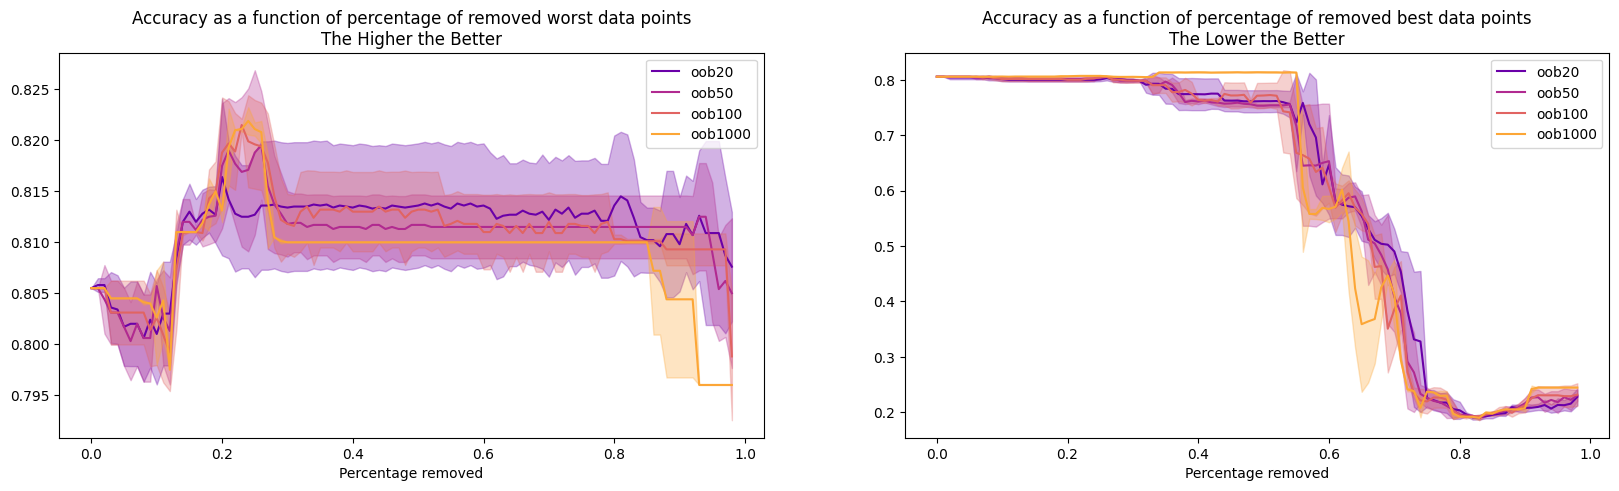

In [46]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="plasma")

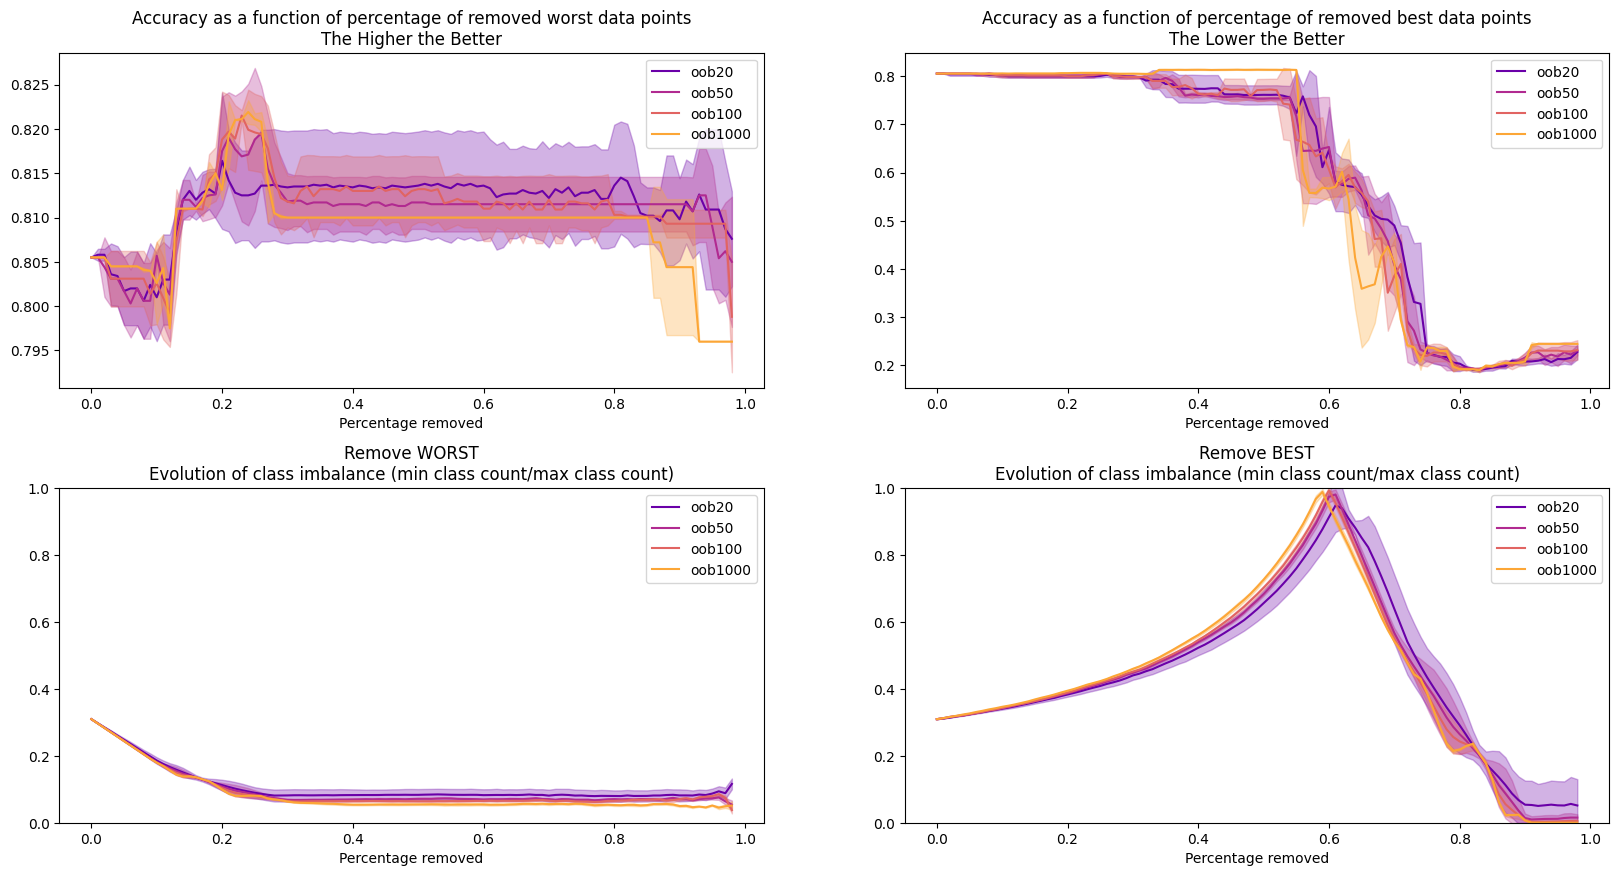

In [47]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="plasma")

# Max_samples

In [ ]:
def oob_func(utility, max_samples):
    return(compute_data_oob(utility, n_est=30, max_samples=max_samples, progress=False))
max_samples_list = [x/10 for x in range(1,9,1)]
func = oob_func
kwargs_list = [{"max_samples":max_samp} for max_samp in max_samples_list]


In [ ]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

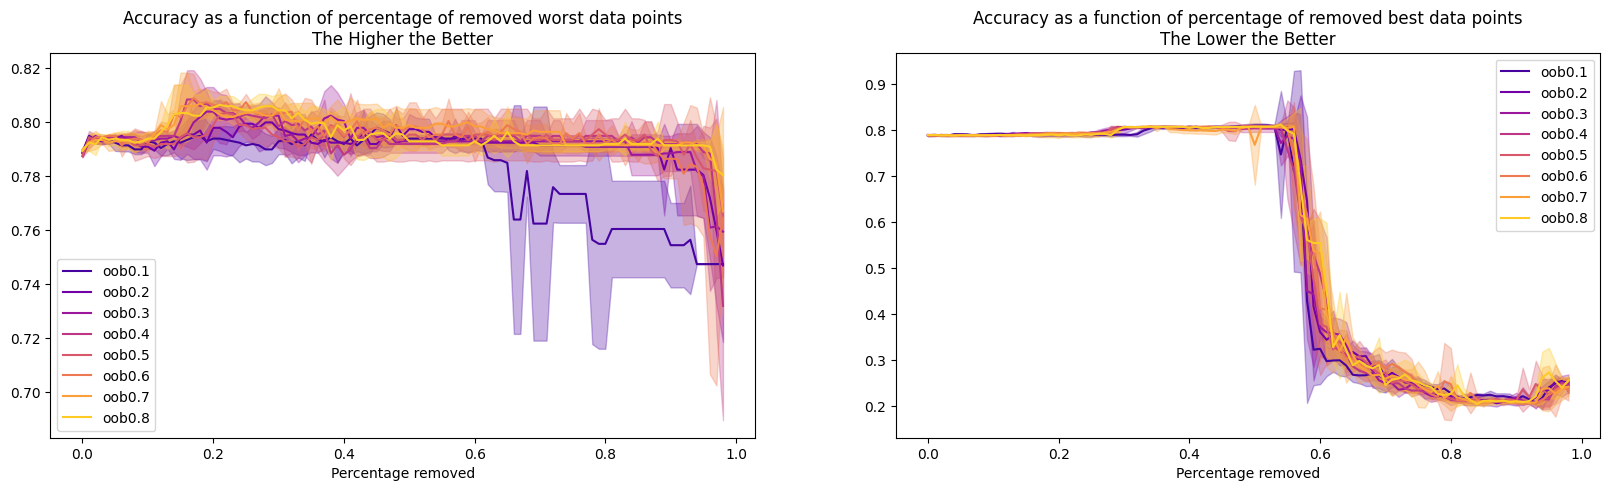

In [ ]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="plasma")

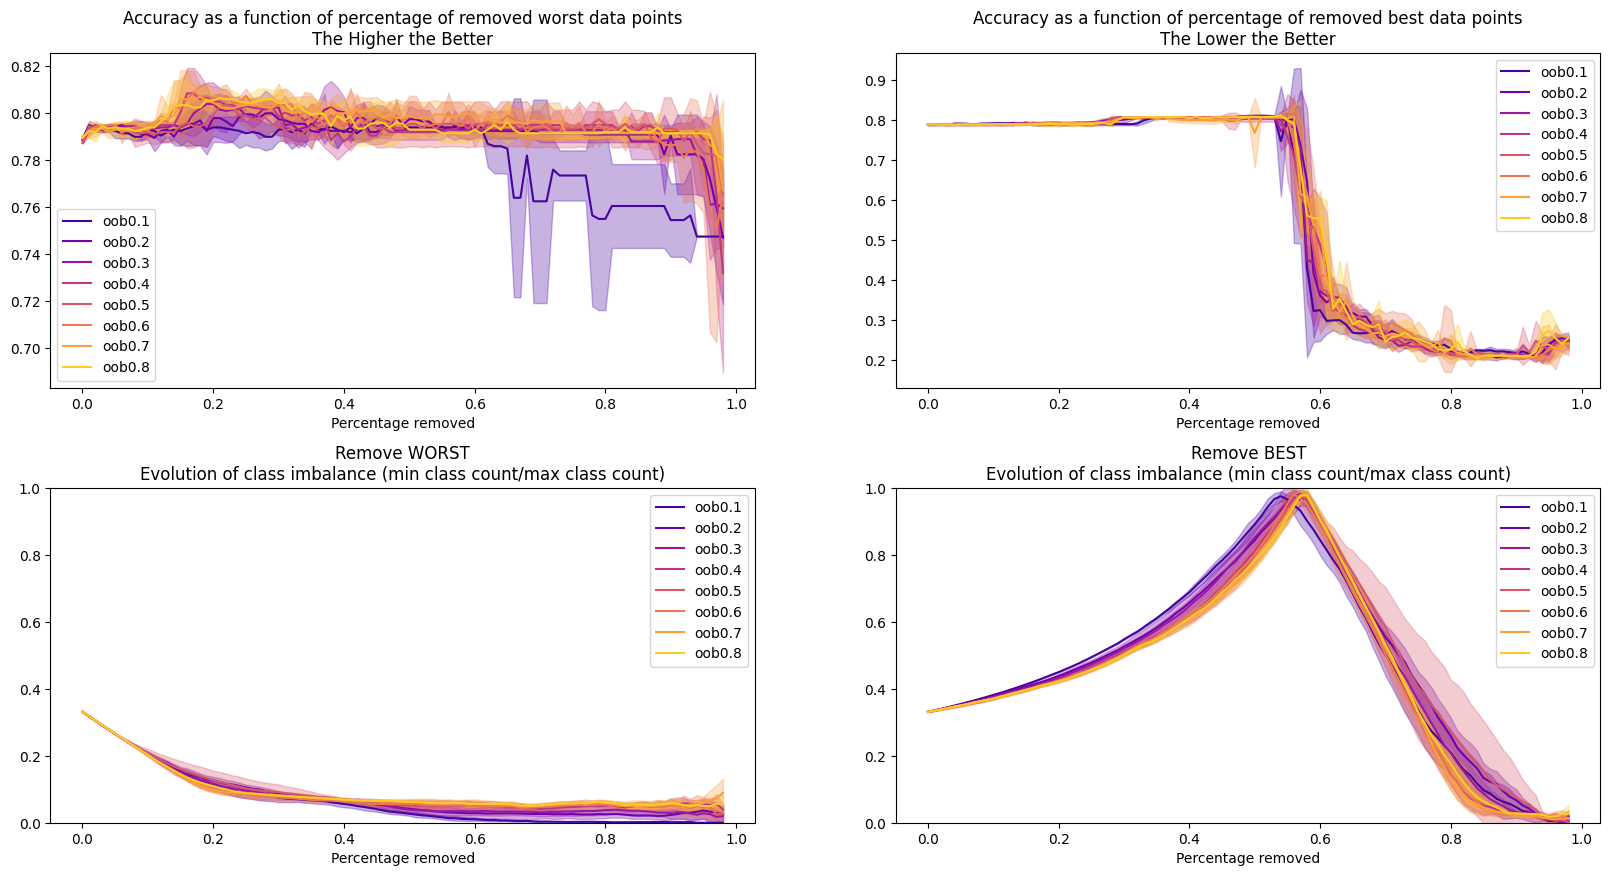

In [ ]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="plasma")

# Base estimator

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF

In [ ]:

model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=2,)
model = LogisticRegression()
scorer = Scorer("accuracy", default=0.0)
dict_utilities = {}
utility = Utility(KNeighborsClassifier(n_neighbors=5), data, scorer)
dict_utilities["KNN"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=2,), data, scorer)
dict_utilities["DecisionTreeShallow"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=20,), data, scorer)
dict_utilities["DecisionTreeDeep"] = utility
#utility = Utility(GaussianProcessClassifier(1.0 * RBF(1.0)), data, scorer)
#dict_utilities["GaussianProcess"] = utility
#utility = Utility(GaussianNB(), data, scorer)
#dict_utilities["GaussianNB"] = utility
#utility = Utility(MLPClassifier(), data, scorer)
#dict_utilities["MLPClassifier"] = utility
utility = Utility(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), data, scorer)
dict_utilities["RandomForest"] = utility
utility = Utility(AdaBoostClassifier(), data, scorer)
dict_utilities["AdaBoost"] = utility
#utility_lr = Utility(LogisticRegression(), data, scorer)
#dict_utilities["KNN"] = utility_knn
utility = Utility(LGBMClassifier(verbose= -1), data, scorer)
dict_utilities["LGBM"] = utility

dict_utilities.keys()

dict_keys(['KNN', 'DecisionTreeShallow', 'DecisionTreeDeep', 'RandomForest', 'AdaBoost', 'LGBM'])

In [ ]:
list(dict_utilities.keys())

['KNN',
 'DecisionTreeShallow',
 'DecisionTreeDeep',
 'RandomForest',
 'AdaBoost',
 'LGBM']

In [ ]:
def oob_func(utility, model_name):
    return(compute_data_oob(dict_utilities[model_name], n_est=30, max_samples=0.8, progress=False))
max_samples_list = np.arange(0.1,0.90,0.1)
func = oob_func
kwargs_list = [{"model_name":m} for m in dict_utilities.keys()]

In [ ]:
model_eval = DecisionTreeClassifier(max_depth=3)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

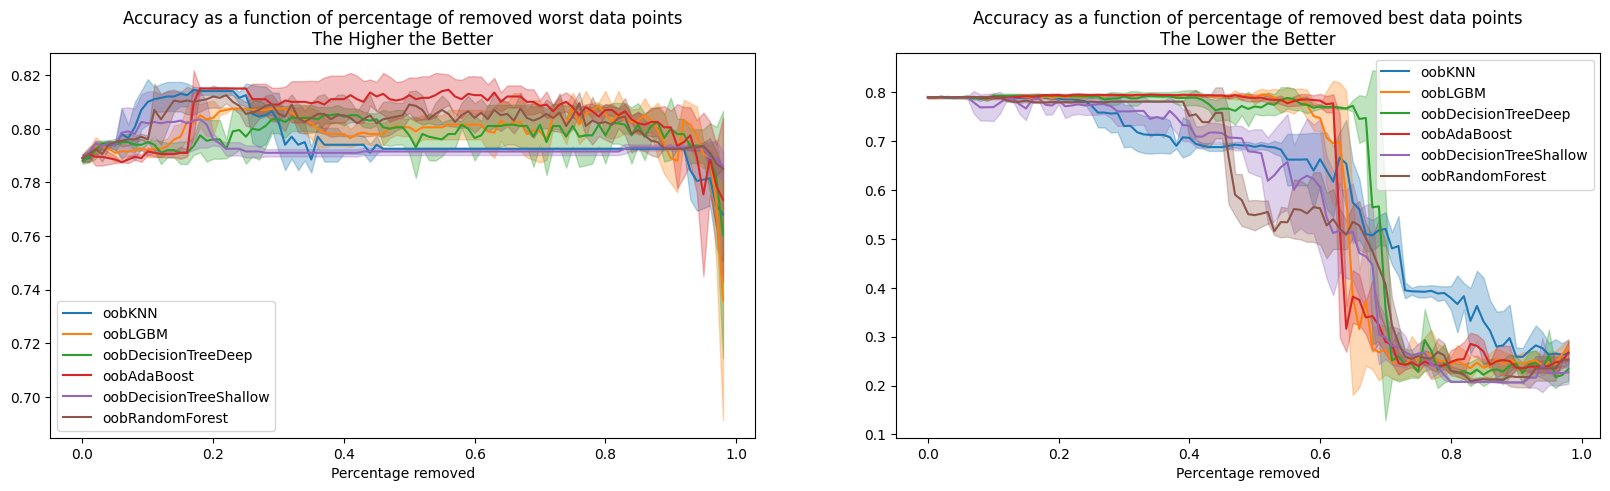

In [ ]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="tab10")

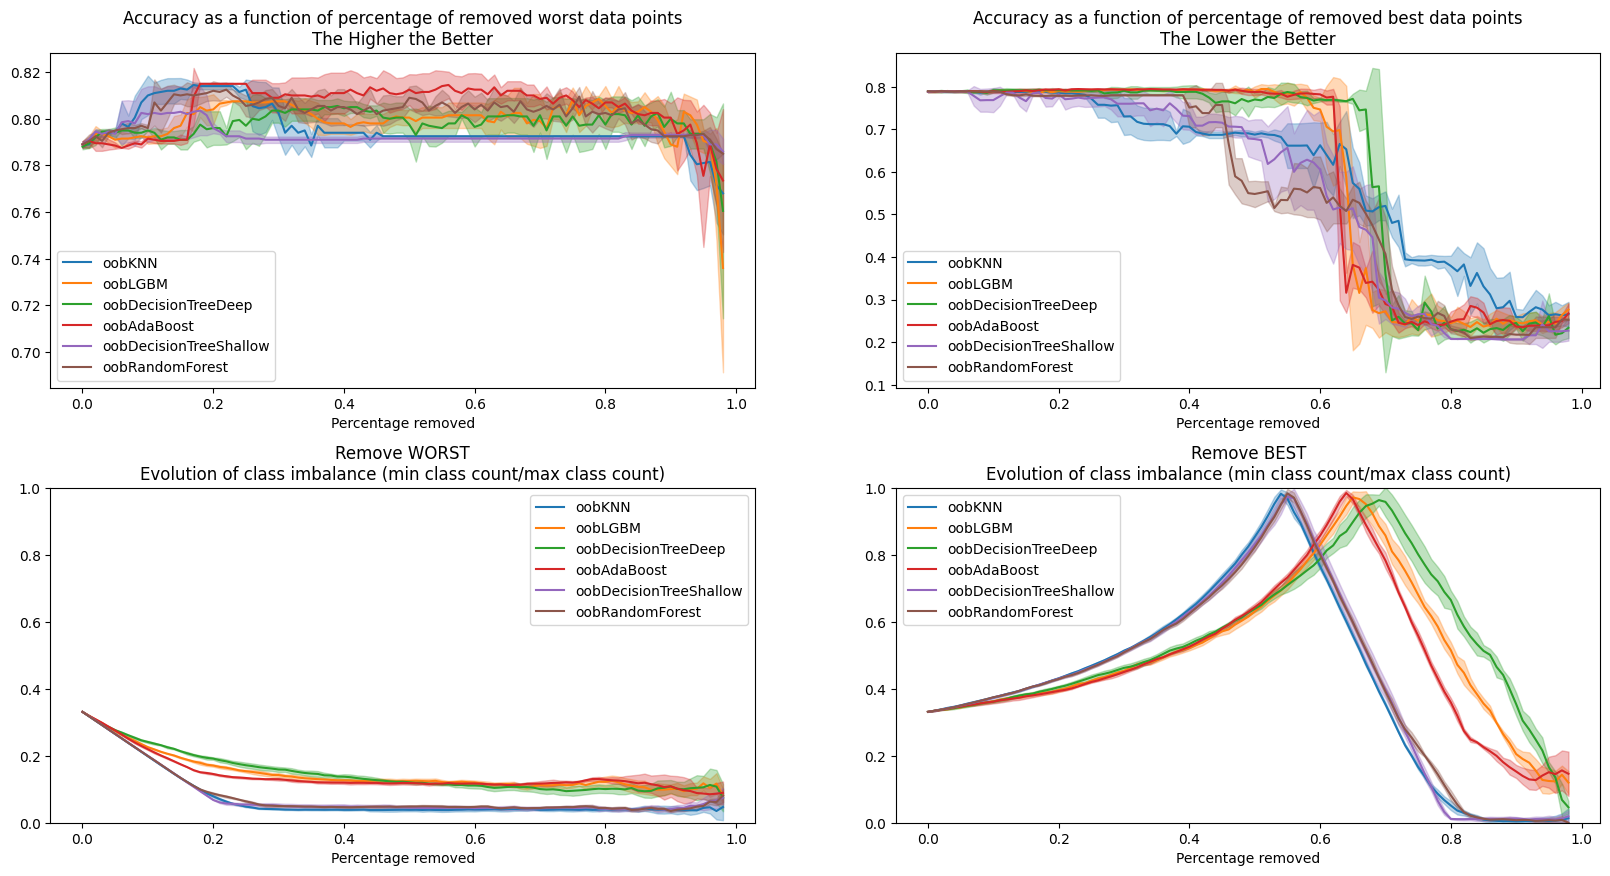

In [ ]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="tab10")

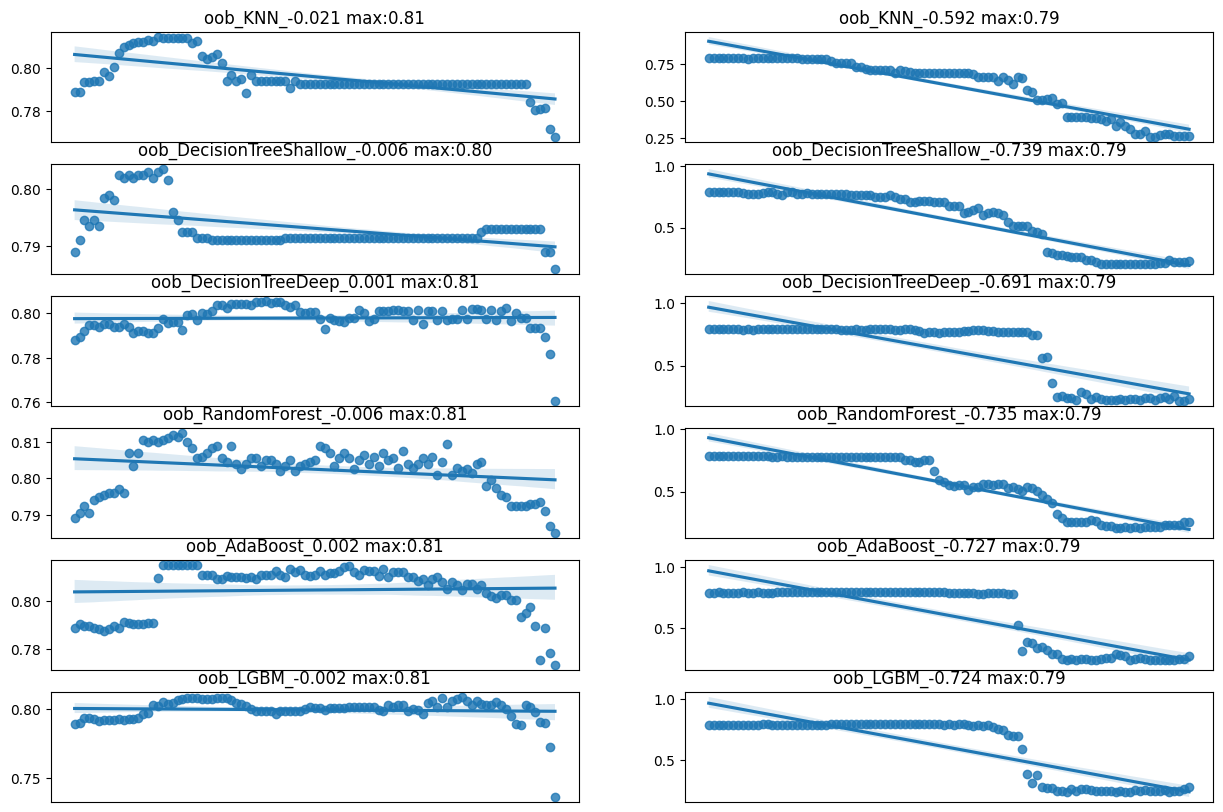

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=best_scores_df.method_name.nunique(), figsize = [15,10])
for i, x in enumerate(best_scores_df.method_name.unique()):
    p=sns.regplot(x=np.arange(len(best_scores_df.groupby("method_name").mean().values[i])), y =best_scores_df.groupby("method_name").mean().loc[x].values, ax=ax[i,1])
    y_data = p.get_lines()[0].get_ydata()
    maxi = best_scores_df.groupby("method_name").mean().loc[x].max()
    ax[i,1].set_title(f"{x}_{y_data[-1]-y_data[0]:.3f} max:{maxi:.2f}")
    ax[i,1].set_xticks([])
    p=sns.regplot(x=np.arange(len(worst_scores_df.groupby("method_name").mean().values[i])), y =worst_scores_df.groupby("method_name").mean().loc[x].values, ax=ax[i,0])
    y_data = p.get_lines()[0].get_ydata()
    maxi = worst_scores_df.groupby("method_name").mean().loc[x].max()
    ax[i,0].set_title(f"{x}_{y_data[-1]-y_data[0]:.3f} max:{maxi:.2f}")
    ax[i,0].set_xticks([])